# PQC Expressivity

In [8]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *
from quantum_circuits import integrable_circuit, nonintegrable_circuit, haar_random
from kraus_channels import *
from utils import saver, loader

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Four Qubits

### Circuit Ensemble

In [5]:
def haar_ensamle_Kl_exact(n):
    d = 2**n
    bins = np.linspace(0, 1, 75)

    F = (bins[1:] + bins[:-1])/2
    P_Haar = (d - 1)*(1-F)**(d-2)
    P_Haar = P_Haar/np.sum(P_Haar)

    return P_Haar


def estimate_ensamble_KL(circuit_type, n, L, reps):
    P_Haar = haar_ensamle_Kl_exact(n)

    fid_list = []
    for i in range(reps):
        U1 = Operator(circuit_type(n, L)).data
        U2 = Operator(circuit_type(n, L)).data
        fid = U1.T.conj()@U2
        fid_list.append(np.abs(fid[0,0])**2)
    
    P_pqc, bins = np.histogram(np.array(fid_list), bins = np.linspace(0, 1, 75))
    P_pqc = P_pqc/np.sum(P_pqc)
    mask = P_pqc > 0
    P_pqc = P_pqc[mask]
    P_Haar = P_Haar[mask]    
    KL = np.sum(P_pqc*np.log(P_pqc/P_Haar))

    return KL



In [ ]:
n = 5
d = 2**n
reps = 10000

np.random.seed(42)

L_max = 10

for L in range(L_max+1):
    KL_list = []
    for i in tqdm(range(10)):
        KL = estimate_ensamble_KL(nonintegrable_circuit, n, L=L, reps=reps)
        KL_list.append(KL)

    saver(KL_list, f"data/KL_list_nonintegrable_L{L}.pkl")


  0%|          | 0/10 [00:00<?, ?it/s]

### Haar Ensemble

In [7]:
n = 5
d = 2**n
reps = 10000

np.random.seed(42)

KL_haar = estimate_ensamble_KL(haar_random, 5, None, reps)

In [15]:
KL_list = loader("data/KL_list_nonintegrable_5.pkl")
KL_list = np.array(KL_list).reshape(11, 10)

In [16]:
KL_mean = np.mean(KL_list, axis=1)
KL_std = np.std(KL_list, axis=1)

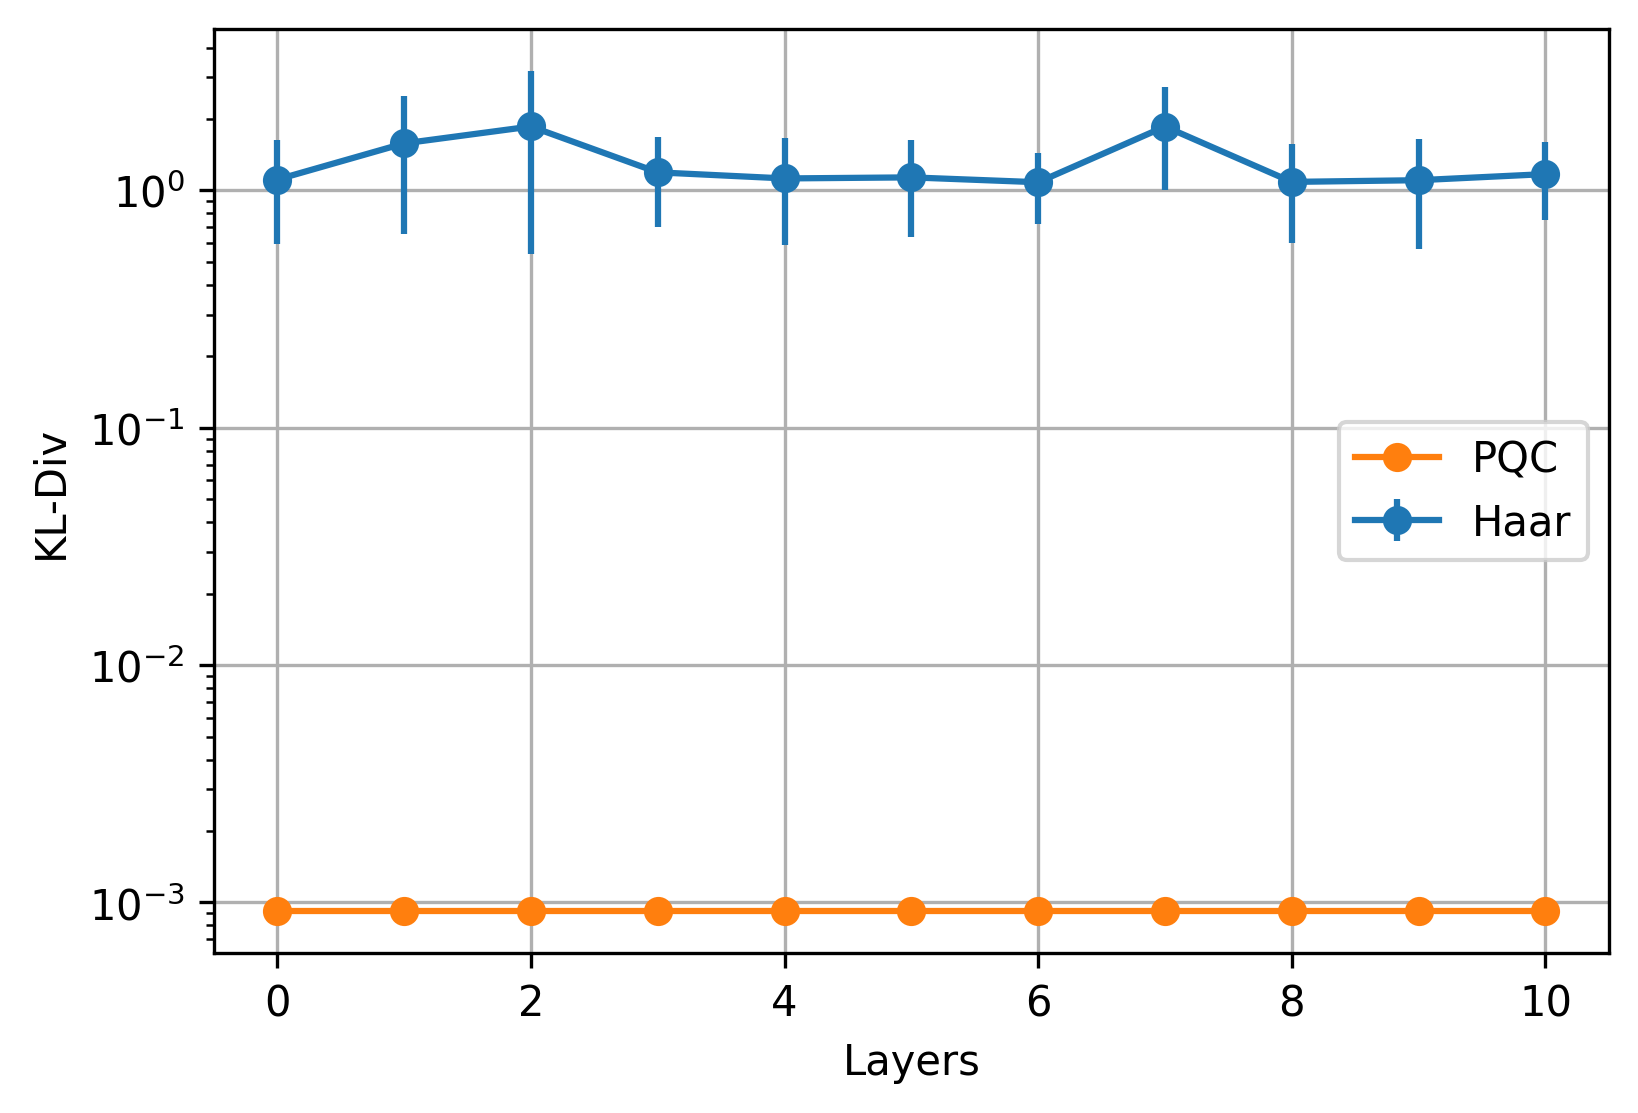

In [17]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
plt.errorbar(list(range(len(KL_list))), KL_mean, KL_std, fmt="o-")
plt.plot(list(range(len(KL_list))), [KL_haar]*len(KL_list), "o-")
plt.grid()
plt.legend(["PQC", "Haar"])
plt.xlabel("Layers")
plt.ylabel("KL-Div")
plt.yscale("log")
plt.show()